In [203]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [243]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', ' Dog', 'Frog', 'Horse', 'Ship',
          'Truck']

In [244]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

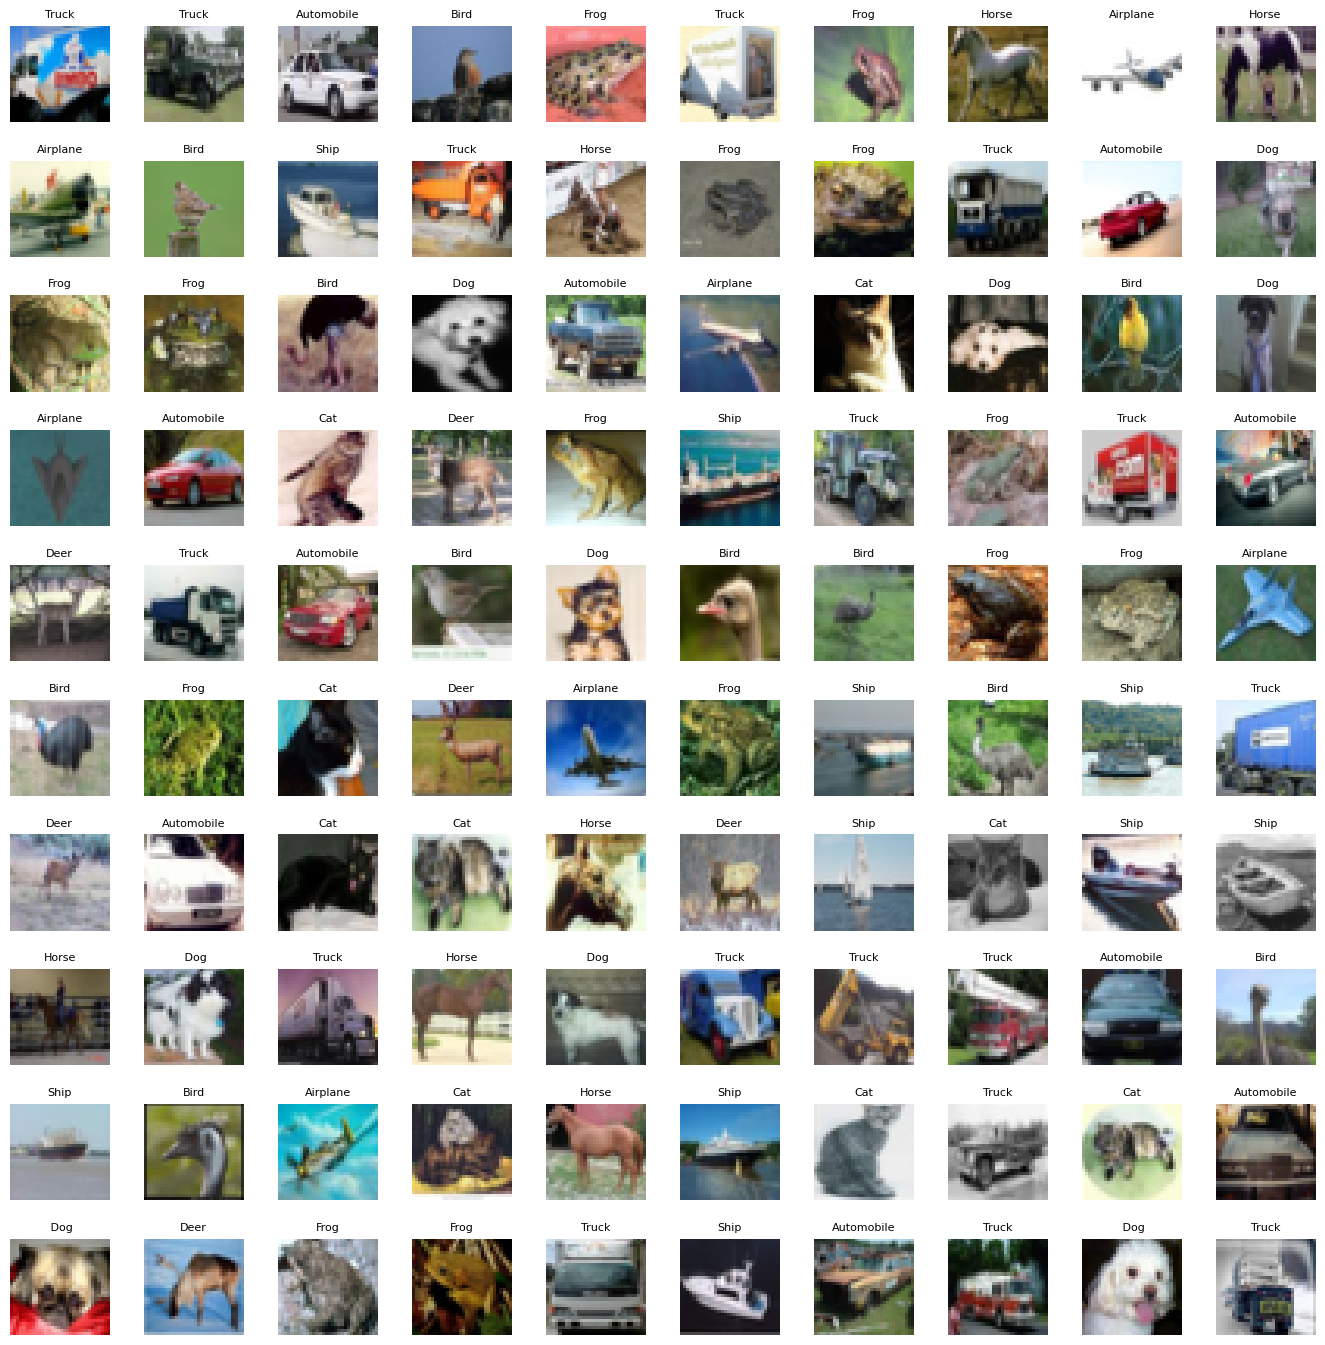

In [193]:
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17, 17))

axes = axes.ravel()

n_train = len(x_train)

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(x_train[index, 1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

In [245]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [268]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [249]:
scaled_train = x_train.reshape(-1, 32, 32, 1) / 255
scaled_test = x_test.reshape(-1, 32, 32, 1) / 255

# 데이터 전처리
### 이미지 크기 정규화
- 이미지는 각 요소가 0~255까지의 값으로 이루어진 픽셀로 구성되어 있다.
- 이를 255로 나누어서 픽셀값이 0~1 사이의 값이 되도록 정규화 한다.

In [250]:
# scaled_train = x_train.reshape / 255.0
# scaled_test = x_test / 255.0

# 종속변수 원핫인코딩으로 바꾸기
y_ohe_train = to_categorical(y_train, 10)
y_ohe_test = to_categorical(y_test, 10)

In [251]:
y_ohe_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# 합성곱 신경망 모델링 주의
- 주의할점
- 1. 층수가 많을수록 복잡한 문제를 해결할 수 있으나, 계산복잡도와 오버피팅 가능성은 높아짐
- 2. 입력이미지가 신경망 층을 거칠 때마다, 대부분 이미지의 size는 작아지지만 층의 depth는 깊어짐
- 3. Conv층 > Pooling층 순서로 설계, 마지막은 FC층을 설꼐하여 분류작업의 효율을 높임
- 4. 은닉층의 활성화 함수는 Relu함수를, 마지막 FC층의 활성화 함수는 Softmax함수를 사용
- 5. FC 전과 후에 droupout층을 설계하여 계산복잡도와 오버피팅 가능성을 낮춤.
- 6. 하이퍼파라미터는 여러번의 시행착오를 거치며 감각을 키움
- 7, 학습할 파라미터의 수 = 필터 수 * 필터크기 * 이전 층 출력 깊이 + 편향

# 합성곱 신경망 모델링

In [252]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (32, 32, 3)))
model.add(BatchNormalization())

In [253]:
# 2번째 Conv층 쌓기 
model.add(Conv2D(filters=32, kernel_size=3, padding = 'same', activation= 'relu'))
model.add(BatchNormalization())

In [254]:
# 풀층 쌓기
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [255]:
# 세번째 Conv층 쌓기 
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation= 'relu'))
model.add(BatchNormalization())

In [256]:
# 드롭아웃 층 쌓기 
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation= 'relu'))
model.add(BatchNormalization())

In [257]:
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [258]:
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation= 'relu'))

In [259]:
model.add(BatchNormalization())

In [260]:
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [261]:
model.add(Flatten())

In [262]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [263]:
model.compile(optimizer= 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [264]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

# 모델 훈련

In [270]:
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [271]:
# 검증 데이터 분할
x_sub, x_val, y_sub, y_val = train_test_split(scaled_train, y_train, test_size = 0.3, stratify = y_train, random_state= 12)

ValueError: Found input variables with inconsistent numbers of samples: [150000, 50000]

In [241]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │              

 Total params: 404,266 (1.54 MB)

 Trainable params: 403,626 (1.54 MB)

 Non-trainable params: 640 (2.50 KB)

In [242]:
history = model.fit(x_sub, y_sub, epochs = 30,validation_data= (x_val, y_val),
                    callbacks = [early_stopping_cb])

Epoch 1/30


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 10)

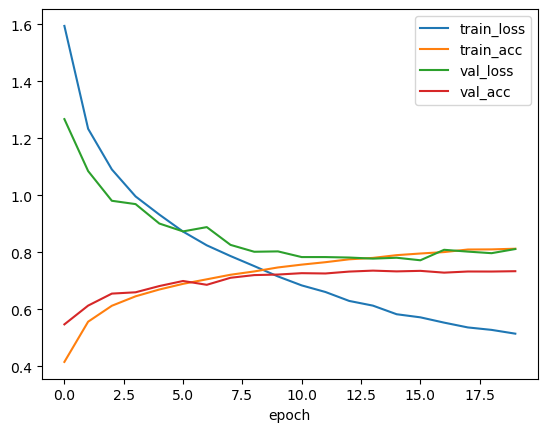

In [25]:
plt.figure()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')

plt.legend()
plt.xlabel('epoch')
plt.show()

# 훈련 로그 확인

In [26]:
history.history

{'accuracy': [0.41591429710388184,
  0.557028591632843,
  0.6129428744316101,
  0.6461142897605896,
  0.6699714064598083,
  0.6898571252822876,
  0.7057428359985352,
  0.7217428684234619,
  0.7333714365959167,
  0.7473714351654053,
  0.7572571635246277,
  0.7657999992370605,
  0.7758857011795044,
  0.7808571457862854,
  0.7904857397079468,
  0.7962571382522583,
  0.8012857437133789,
  0.8102571368217468,
  0.8107143044471741,
  0.8130571246147156],
 'loss': [1.5947028398513794,
  1.2338175773620605,
  1.0911763906478882,
  0.9964478015899658,
  0.9328488111495972,
  0.873195469379425,
  0.8249795436859131,
  0.7873392105102539,
  0.7520878911018372,
  0.7157812118530273,
  0.6843619346618652,
  0.6612368822097778,
  0.6299090385437012,
  0.6134202480316162,
  0.5832057595252991,
  0.5723249912261963,
  0.5537673234939575,
  0.5369138717651367,
  0.5283069610595703,
  0.5150375366210938],
 'val_accuracy': [0.5476666688919067,
  0.6134666800498962,
  0.6556000113487244,
  0.6601999998092

In [27]:
model.evaluate(scaled_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7315 - loss: 0.7835


[0.7823136448860168, 0.7343000173568726]

In [28]:
preds = model.predict(scaled_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
preds.shape

(10000, 10)

In [30]:
preds[0]

array([2.0941510e-04, 5.9880989e-05, 1.0322168e-03, 4.5428741e-01,
       1.5639573e-04, 5.3833848e-01, 1.5178330e-03, 7.3691961e-05,
       4.2919102e-03, 3.2718333e-05], dtype=float32)

In [31]:
# 예측이 제pred_arr일 큰 값
pred_arr = np.argmax(preds, axis = 1)

In [32]:
pred_arr

array([5, 8, 8, ..., 5, 1, 7], dtype=int64)

In [33]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [38]:
# 못 맞힌 애들 뽑아보기
x_match = []

for idx, item in enumerate(pred_arr):
    if item != y_test[idx]:
        x_match.append(idx)

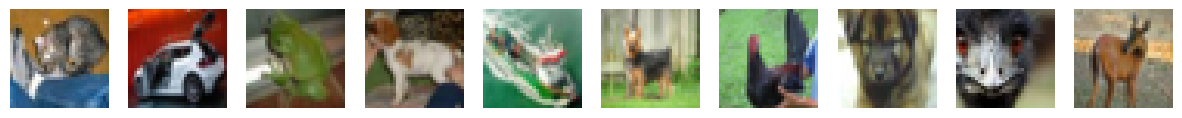

In [39]:
# 못 맞힌 애들 뽑아보기
fig, axs = plt.subplots(1, 10, figsize = (15, 15))

for i, item in enumerate(x_match[:10]):
    axs[i].imshow(x_test[item], cmap = 'gray_r')
    axs[i].axis('off')
    
plt.show()